# Imports

In [30]:
import os, gc
import torch
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)

# Initial setup

## GPU

In [31]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Pytorch lightning and forecasting

In [32]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer

# Load input

In [33]:
import sys
sys.path.append( '..' )
from script.utils import *
from dataclasses import dataclass

@dataclass
class args:
    result_folder = '../results/TFT_baseline'
    figPath = os.path.join(result_folder, 'figures')
    checkpoint_folder = os.path.join(result_folder, 'checkpoints')
    input_filePath = '../2022_May_cleaned/Top_100.csv'

    configPath = '../configurations/baseline.json'
    # configPath = '../config_2022_August.json'

    model_path = get_best_model_path(checkpoint_folder)

    # set this to false when submitting batch script, otherwise it prints a lot of lines
    show_progress_bar = True

    # interpret_output has high memory requirement
    # results in out-of-memery for Total.csv and a model of hidden size 64, even with 64GB memory
    interpret_train = 'Total.csv' not in input_filePath

Checkpoint model best-epoch=3.ckpt.


In [34]:
start = datetime.now()
print(f'Started at {start}')

total_data = pd.read_csv(args.input_filePath)
print(total_data.shape)
total_data.head()

Started at 2023-04-05 18:30:19.934698
(80900, 12)


,FIPS,AgeDist,HealthDisp,Date,DiseaseSpread,Transmission,VaccinationFull,SocialDist,Cases,TimeFromStart,SinWeekly,CosWeekly
0,2261,0.014,8.8,2020-02-29,0.0,0.0,0.0,0.5,0.0,0,-0.975,-0.223
1,2261,0.014,8.8,2020-03-01,0.0,0.0,0.0,0.5,0.0,1,-0.782,0.623
2,2261,0.014,8.8,2020-03-02,0.0,0.0,0.0,0.5,0.0,2,0.000,1.000
3,2261,0.014,8.8,2020-03-03,0.0,0.0,0.0,0.5,0.0,3,0.782,0.623
4,2261,0.014,8.8,2020-03-04,0.0,0.0,0.0,0.5,0.0,4,0.975,-0.223


# Config

In [35]:
import json
from Class.Parameters import Parameters

with open(args.configPath, 'r') as input_file:
  config = json.load(input_file)

parameters = Parameters(config, **config)

In [36]:
targets = parameters.data.targets
time_idx = parameters.data.time_idx
tft_params = parameters.model_parameters

batch_size = tft_params.batch_size
max_prediction_length = tft_params.target_sequence_length
max_encoder_length = tft_params.input_sequence_length

In [37]:
split = parameters.data.split
# split.test_start = to_datetime('2021-11-01')
# split.test_end = to_datetime('2021-12-29')

# Processing

In [38]:
total_data['Date'] = pd.to_datetime(total_data['Date'].values) 
total_data['FIPS'] = total_data['FIPS'].astype(str)
print(f"There are {total_data['FIPS'].nunique()} unique counties in the dataset.")

There are 100 unique counties in the dataset.


## Adapt input to encoder length
Input data length needs to be a multiple of encoder length to created batch data loaders.

In [39]:
train_start = parameters.data.split.train_start
total_data = total_data[total_data['Date']>=train_start]
total_data[time_idx] = (total_data["Date"] - total_data["Date"].min()).apply(lambda x: x.days)

## Train validation test split and scaling

In [40]:
train_data, validation_data, test_data = train_validation_test_split(
    total_data, parameters
)

Train samples 64000, validation samples 2800, test samples 2800
640 days of training, 15 days of validation data, 15 days of test data.


In [41]:
train_scaled, _, test_scaled, target_scaler = scale_data(
    train_data, validation_data, test_data, parameters
)

Scaling static and dynamic input features: ['AgeDist', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']
Scaling targets ['Cases']


## Create dataset and dataloaders

In [42]:
def prepare_data(data: pd.DataFrame, pm: Parameters, train=False):
  data_timeseries = TimeSeriesDataSet(
    data,
    time_idx= time_idx,
    target=targets,
    group_ids=pm.data.id, 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_reals=pm.data.static_features,
    # static_categoricals=['FIPS'],
    time_varying_known_reals = pm.data.time_varying_known_features,
    time_varying_unknown_reals = pm.data.time_varying_unknown_features,
    target_normalizer = MultiNormalizer(
      [GroupNormalizer(groups=pm.data.id) for _ in range(len(targets))]
    )
  )

  if train:
    dataloader = data_timeseries.to_dataloader(train=True, batch_size=batch_size)
  else:
    dataloader = data_timeseries.to_dataloader(train=False, batch_size=batch_size*8)

  return data_timeseries, dataloader

In [43]:
_, train_dataloader = prepare_data(train_scaled, parameters)
_, test_dataloader = prepare_data(test_scaled, parameters)

gc.collect()

16

# Model

In [44]:
tft = TemporalFusionTransformer.load_from_checkpoint(args.model_path)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 20.4k


# Prediction Processor and PlotResults

In [45]:
from Class.PredictionProcessor import PredictionProcessor

processor = PredictionProcessor(
    time_idx, parameters.data.id[0], max_prediction_length, targets, 
    train_start, max_encoder_length
)

In [46]:
from Class.Plotter import *

plotter = PlotResults(args.figPath, targets, show=args.show_progress_bar)

# Evaluate

In [47]:
if args.interpret_train:
    dataloader = train_dataloader
    data = train_data
    print(f'\n---Train results--\n')
    
else:
    dataloader = test_dataloader
    data = test_data
    print(f'\n---Test results--\n')


---Train results--



In [48]:
raw_predictions, index = tft.predict(
    dataloader, mode="raw", return_index=True, 
    show_progress_bar=args.show_progress_bar
)
predictions = upscale_prediction(
    targets, raw_predictions['prediction'], 
    target_scaler, max_prediction_length
)

result_merged = processor.align_result_with_dataset(
    data, predictions, index
)
show_result(result_merged, targets)
gc.collect()

Predict:   0%|          | 0/120 [00:00<?, ? batches/s]

Target Cases, MAE 106.25, RMSE 292.29, RMSLE 1.5382, SMAPE 0.56589. NNSE 0.82983.



58

# Interpret

## Weight plotter

In [49]:
plotWeights = PlotWeights(
    args.figPath, max_encoder_length, 
    tft, show=args.show_progress_bar
)

## Attention weights

In [50]:
attention_mean, attention = processor.get_mean_attention(
    tft.interpret_output(raw_predictions), 
    index, return_attention=True
)

gc.collect()

0

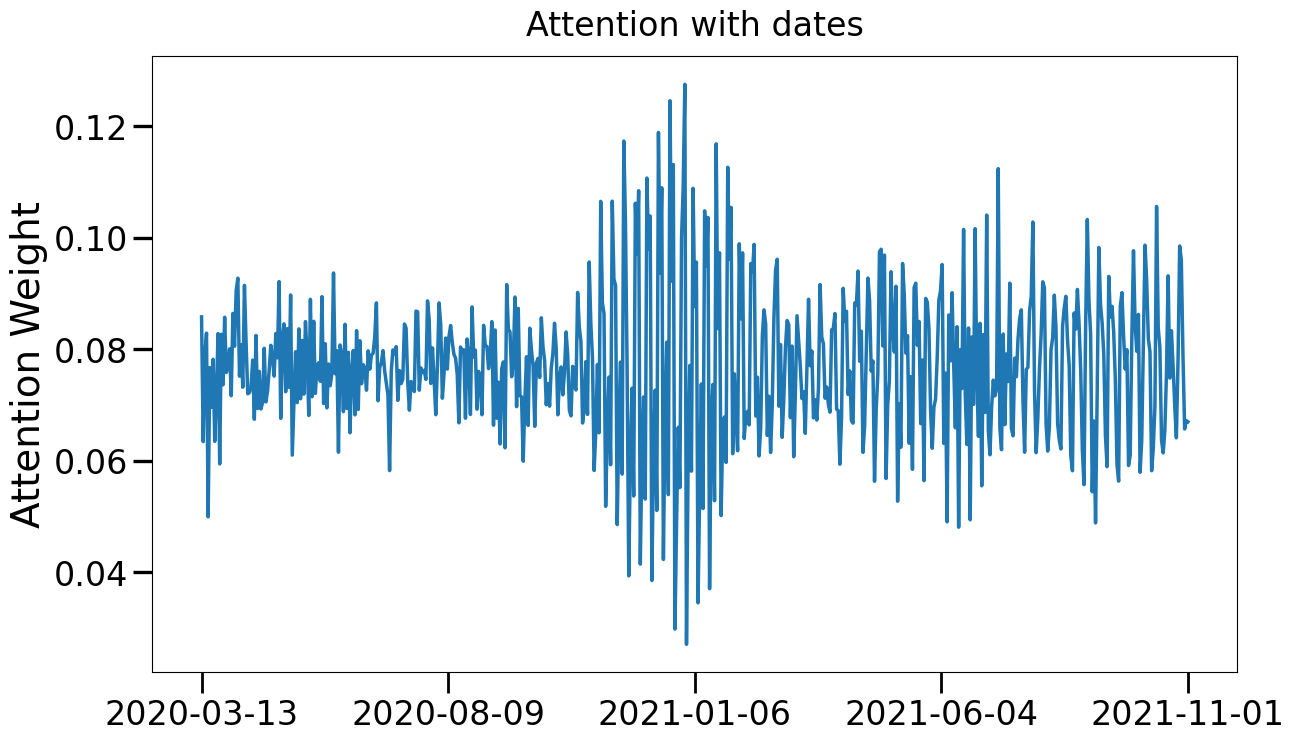

Weekdays when these attentions are maximum: 
[(-13, 'Sun'), (-12, 'Thu'), (-11, 'Mon'), (-10, 'Wed'), (-9, 'Tues'), (-8, 'Tues'), (-7, 'Mon'), (-6, 'Thu'), (-5, 'Thu'), (-4, 'Mon'), (-3, 'Wed'), (-2, 'Tues'), (-1, 'Wed')]


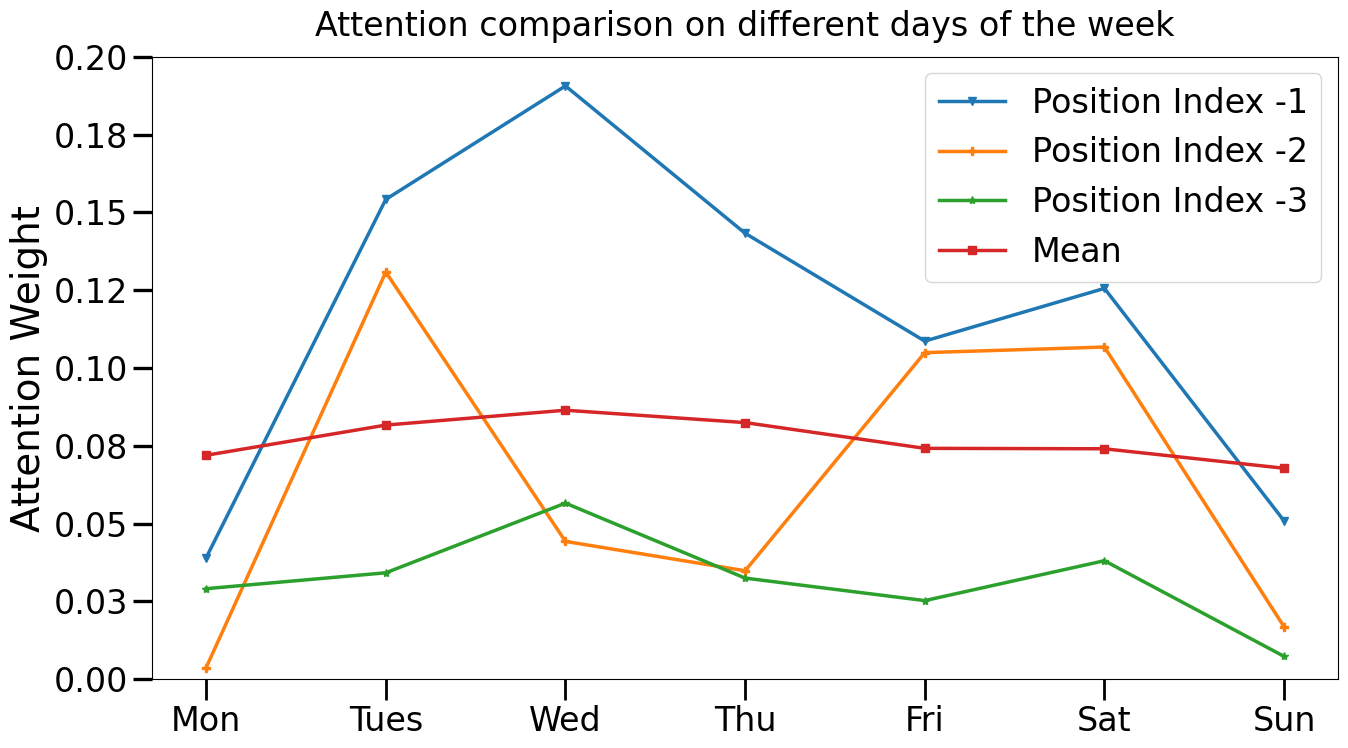

In [51]:
# uncomment the figure name, if you want to save the image
plotWeights.plot_attention(
    attention_mean, 
    limit=0, enable_markers=False, title='Attention with dates',
    # figure_name='Train_daily_attention', 
)
gc.collect()
attention_weekly = processor.get_attention_by_weekday(attention_mean)
plotWeights.plot_weekly_attention(
    attention_weekly, 
    # figure_name='Train_weekly_attention'
)

## Dump

In [52]:
# attention_mean.round(3).to_csv(
#     os.path.join(plotWeights.figPath, 'attention_mean.csv'), 
#     index=False
# )
# attention.round(3).to_csv(
#     os.path.join(plotWeights.figPath, 'attention.csv'), 
#     index=False
# )

In [53]:
# if it is validation/test attention, you might want to
# attach it to the end of train attention

# df = pd.read_csv('../results/TFT_baseline/figures/attention.csv')
# df['Date'] = to_datetime(df['Date'])

# encoder_indices = list(range(max_encoder_length))
# df.rename(
#     {str(index):index for index in encoder_indices}, 
#     axis=1, inplace=True
# )

# attention = attention[attention['Date']>df['Date'].max()]
# attention = pd.concat([df, attention], axis=0)

# attention.round(3).to_csv(
#     os.path.join(plotWeights.figPath, 'attention.csv')
#     , index=False
# )

## Variable importance

In [54]:
interpretation = tft.interpret_output(
    raw_predictions, reduction="sum"
)
print(f'Interpretation:\n{interpretation}')

{'attention': tensor([ 2970.3408,  1146.9807,  1070.8999,  1498.8114,  2606.9207,  4688.3237,
        28268.6895,  5522.0205,  2095.5249,  1500.1967,  2059.9045,  4280.4307,
         7410.0474]), 'static_variables': tensor([33717.7227, 27582.2773]), 'encoder_variables': tensor([10219.8760,  6490.4668, 10091.0820,  1969.8088,  6884.2104,  2244.8389,
        23399.7148]), 'decoder_variables': tensor([44659.9648, 16640.0332]), 'encoder_length_histogram': tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 61300]), 'decoder_length_histogram': tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 61300])}


In [60]:
results = pd.DataFrame(columns=['Feature', 'Importance', 'Normalized', 'Type'])

for key in interpretation.keys():
    if '_variables' not in key: continue

    features = tft.__getattribute__(key)
    importance = interpretation[key]
    normalized = importance*100/torch.sum(importance)

    for index in range(len(features)):
        results.loc[len(results.index)] =  [
            features[index], importance[index].item(), normalized[index].item(), key
        ]

    print(f'{key}: {features}')
    print(f'Importance: {importance}')
    print(f'Normalized: {normalized}\n')

static_variables: ['AgeDist', 'HealthDisp']
Importance: tensor([33717.7227, 27582.2773])
Normalized: tensor([55.0044, 44.9956])

encoder_variables: ['SinWeekly', 'CosWeekly', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist', 'Cases']
Importance: tensor([10219.8760,  6490.4668, 10091.0820,  1969.8088,  6884.2104,  2244.8389,
        23399.7148])
Normalized: tensor([16.6719, 10.5880, 16.4618,  3.2134, 11.2304,  3.6621, 38.1725])

decoder_variables: ['SinWeekly', 'CosWeekly']
Importance: tensor([44659.9648, 16640.0332])
Normalized: tensor([72.8548, 27.1452])



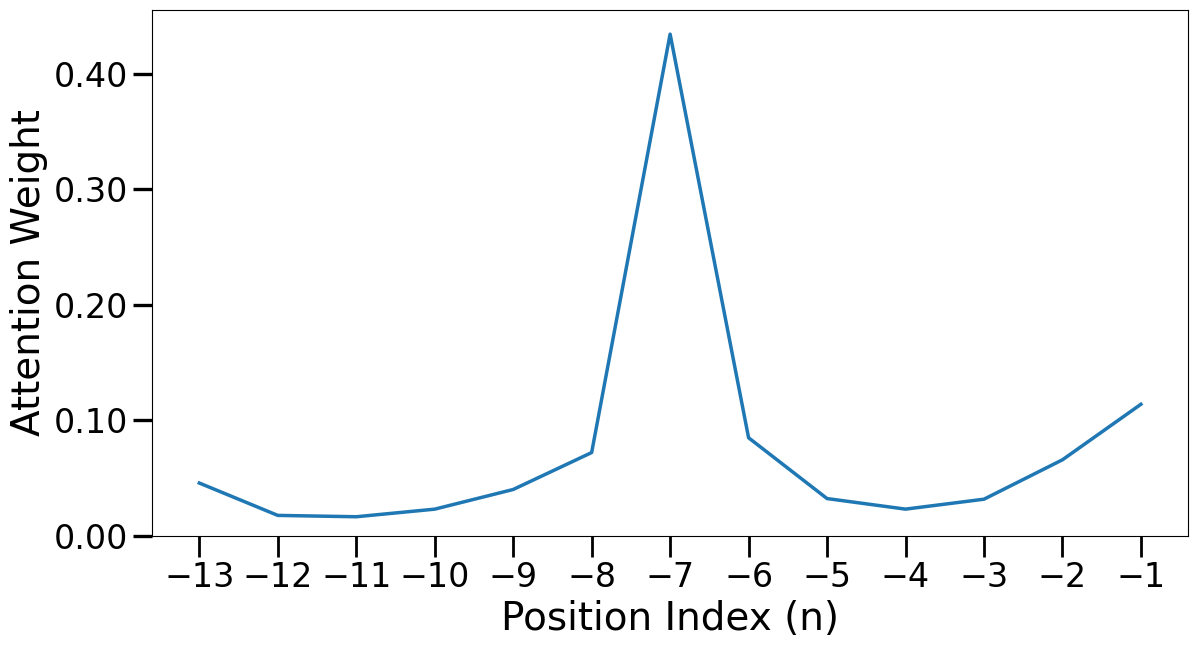

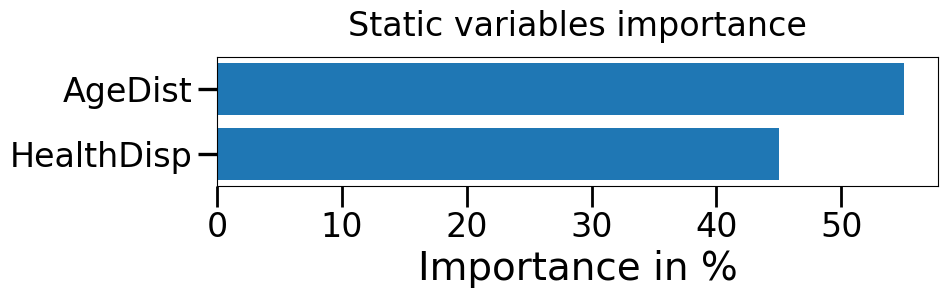

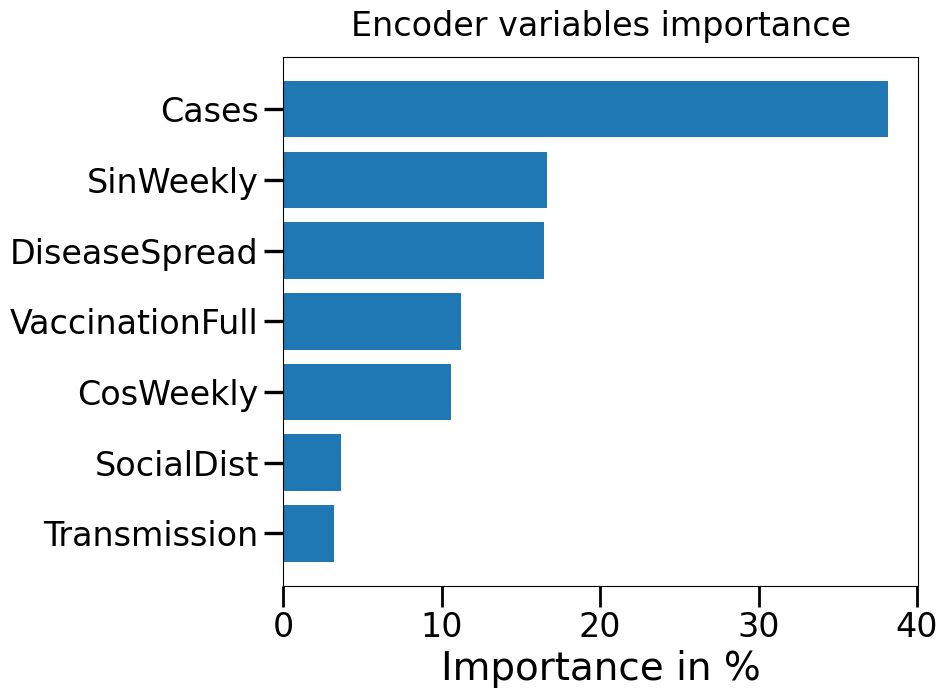

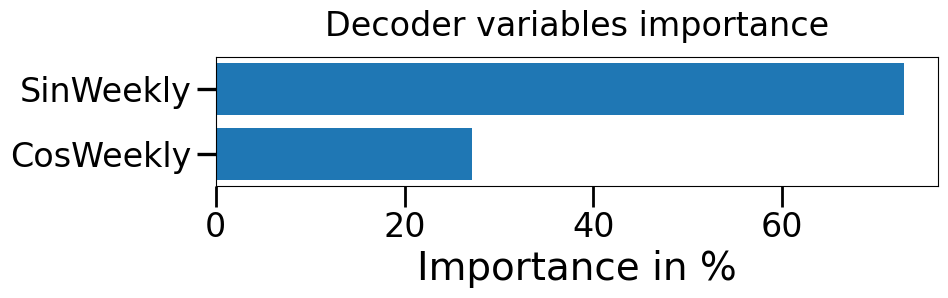

In [56]:
figures = plotWeights.plot_interpretation(interpretation)
for key in figures.keys():
    figure = figures[key]
    if args.interpret_train:
        figure.savefig(os.path.join(plotter.figPath, f'Train_{key}.jpg'), dpi=DPI) 
    else:
        figure.savefig(os.path.join(plotter.figPath, f'Test_{key}.jpg'), dpi=DPI)

In [61]:
results.round(3).to_csv(
    os.path.join(args.figPath, 'importance.csv'), 
    index=False
)

# End

In [58]:
print(f'Ended at {datetime.now()}. Elapsed time {datetime.now() - start}')

Ended at 2023-04-05 18:30:49.620429. Elapsed time 0:00:29.685731
